# Pneummonia detection image classifier

In this project we'll set up a CNN model to predict on a famous tensorflow dataset.

In [1]:
import numpy as np 
import tensorflow as tf 
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 

## Preprocessing

### Importing and splitting the data 

In [2]:
import tensorflow_datasets as tfds

# Load the entire dataset as a single split
# The `+` operator combines splits.
ds_full, ds_info = tfds.load(
    'pneumonia_mnist',
    split='train+val',
    as_supervised=True,
    with_info=True
)

# Get the number of examples in the full combined dataset
num_examples = ds_full.cardinality().numpy()

# Define the ratio for the new splits (80% for training, 20% for validation)
train_split_size = int(0.8 * num_examples)
test_split_size = num_examples - train_split_size

# Shuffle the dataset to ensure a random split
ds_full = ds_full.shuffle(buffer_size=num_examples)

# Create the new training and validation datasets
ds_train_custom = ds_full.take(train_split_size)
ds_test_custom = ds_full.skip(train_split_size)

full_size = ds_full.cardinality().numpy() 
train_size = ds_train_custom.cardinality().numpy() 
test_size = ds_test_custom.cardinality().numpy()

print(f"Training size: {train_size} ({train_size / full_size * 100:.0f}%)")
print(f"Testing size: {test_size} ({test_size / full_size * 100:.0f}%)") 

Training size: 4185 (80%)
Testing size: 1047 (20%)


In [3]:
# Exploring the types 
print(type(ds_train_custom)) 
print(type(ds_train_custom.cardinality())) 
print(type(ds_full.cardinality().numpy()))

<class 'tensorflow.python.data.ops.take_op._TakeDataset'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'numpy.int64'>


### Turning the data into tensorflow's Tensor object

In [4]:
train_images_list, train_labels_list = [], [] 
test_images_list , test_labels_list = [], []

for image, label in ds_train_custom:
    train_images_list.append(image)
    train_labels_list.append(label)

for image, label in ds_test_custom:
    test_images_list.append(image)
    test_labels_list.append(label)

X_train = tf.cast(tf.stack(train_images_list, axis=0), dtype=tf.float16)
y_train = tf.cast(tf.stack(train_labels_list, axis=0), dtype=tf.float16)
X_test = tf.cast(tf.stack(test_images_list, axis=0), dtype=tf.float16) 
y_test = tf.cast(tf.stack(test_labels_list, axis=0), dtype=tf.float16)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape) 
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape) 

Shape of X_train: (4185, 28, 28, 1)
Shape of X_test: (1047, 28, 28, 1)
Shape of y_train: (4185,)
Shape of y_test: (1047,)


### Normalizing and squeezing the features 

In [5]:
X_train = tf.squeeze(X_train) 
X_test = tf.squeeze(X_test) 
X_train_normal, X_test_normal = X_train/255, X_test/255

### Visualizing a random sample

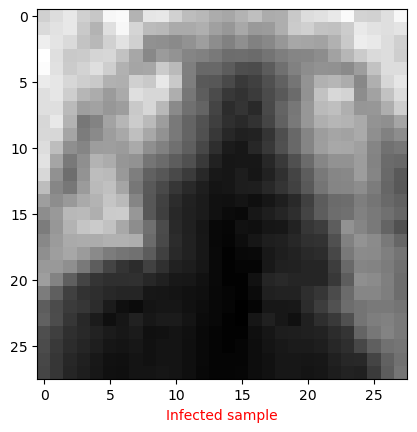

In [6]:
random_index = np.random.randint(0, len(X_test)) 

plt.imshow(X_test[random_index], cmap='binary') 
if int(y_test[random_index]): 
    plt.xlabel("Infected sample", color='red') 
else: 
    plt.xlabel("Normal sample", color='green') 
plt.show()

## Building the model

### Training loop

In [12]:
tf.random.set_seed(42)

xray_clf = Sequential([
    Flatten(), 
    Dense(7, activation='relu'), 
    Dense(7, activation='relu'), 
    Dense(7, activation='relu'), 
    Dense(1, activation='sigmoid') 
]) 

xray_clf.compile(
    loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.03), 
                metrics=["accuracy"]
) 

history = xray_clf.fit(X_train_normal, y_train, epochs=40)

Epoch 1/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7884 - loss: 0.4917
Epoch 2/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9096 - loss: 0.2271
Epoch 3/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9106 - loss: 0.2233
Epoch 4/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9176 - loss: 0.2040
Epoch 5/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9325 - loss: 0.1679
Epoch 6/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9334 - loss: 0.1678
Epoch 7/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9290 - loss: 0.1927
Epoch 8/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9157 - loss: 0.2013
Epoch 9/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9349 - loss: 0.1698
Epoch 10/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9292 - loss: 0.1842
Epoch 11/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9433 - loss: 0.1515
Epoch 12/40
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

### Testing

In [13]:
loss, accuracy = xray_clf.evaluate(X_test_normal, y_test, verbose=0) 

y_prob = xray_clf.predict(X_test_normal) 
y_pred = np.round(y_prob)

print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%") 
print(f"Confusion matrix:\n{confusion_matrix(y_test, y_pred)}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model loss on test set: 0.13985207676887512
Model accuracy on test set: 94.36%
Confusion matrix:
[[265   9]
 [ 50 723]]


### Make random prediction with visualization on test data

In [14]:
type(X_test)

tensorflow.python.framework.ops.EagerTensor

In [15]:
# Create a function for plotting a random image along with its prediction
def plot_random_image(model, input_images, true_labels, classes:dict):
    
    # Setup random integer
    i = np.random.randint(0, len(input_images))
  
    # Create predictions and targets
    target_image = input_images[i] 
    pred_probs = model.predict(tf.reshape(target_image, (1,28,28))) # have to reshape to get into right size for model
    pred_label = classes[int(np.round(pred_probs))]
    true_label = classes[int(true_labels[i])]
  
    # Plot the target image
    plt.imshow(target_image, cmap='binary')

    # Change the color of the titles depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    # Add xlabel information (prediction/true label)
    plt.xlabel(f"Pred: {pred_label} ({100*tf.reduce_max(pred_probs):2.0f}%) (True: {true_label})",
               color=color) # set the color to green or red

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


C:\Users\amesh\AppData\Local\Temp\ipykernel_10572\3389131340.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = classes[int(np.round(pred_probs))]


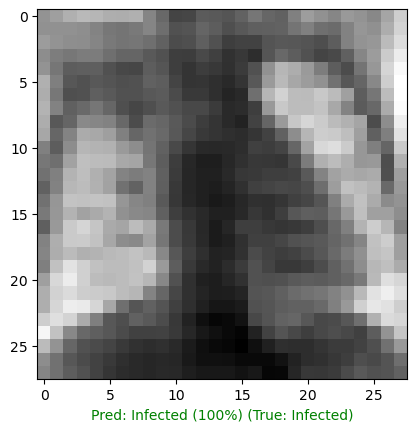

In [16]:
class_dict = {0: 'Normal',
              1: 'Infected'} 
plot_random_image(model=xray_clf,
                  input_images=X_test, 
                  true_labels=y_test,
                  classes=class_dict)